In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import glob
import os
import matplotlib.pyplot as plt
import yaml
import sys

from tqdm import tqdm
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset
from scipy.stats import ks_2samp
from statsmodels.distributions.empirical_distribution import ECDF

sys.path.append("../../../../utils")
from absolute_path_builder import AbsolutePathBuilder

In [2]:
plt.rcParams['figure.figsize']  = (3.33, 5.5)
plt.rcParams['axes.labelsize']  = 20
plt.rcParams['axes.titlesize']  = 24
plt.rcParams['legend.fontsize'] = 16
plt.rcParams['xtick.labelsize'] = 20
plt.rcParams['ytick.labelsize'] = 20
plt.rcParams['lines.linewidth'] = 3

In [3]:
twitter_datapath = AbsolutePathBuilder.get_path(
    "04_twitter_scored",
    filepaths="../../../../config/filepaths.yaml"
)

In [4]:
filenames = [file.split("/")[-1] for file in glob.glob(os.path.join(twitter_datapath, "*"))]

data = []
for filename in filenames:
    description = {}
    
    description["filename"] = filename
    description["group"] = filename.split("_")[0]
    
    data.append(description)
    
df_data_desc = pd.DataFrame(data)

df_data_desc["group"] = (
    df_data_desc
    .group.apply(
        lambda group: "Black"
        if group=='aa'
        else "White"
    )
)

---

### Toxicity Score Cumulative Distribution Function (CDF)

100%|███████████████████████████████████████████████████████████████████| 6/6 [00:02<00:00,  2.63it/s]


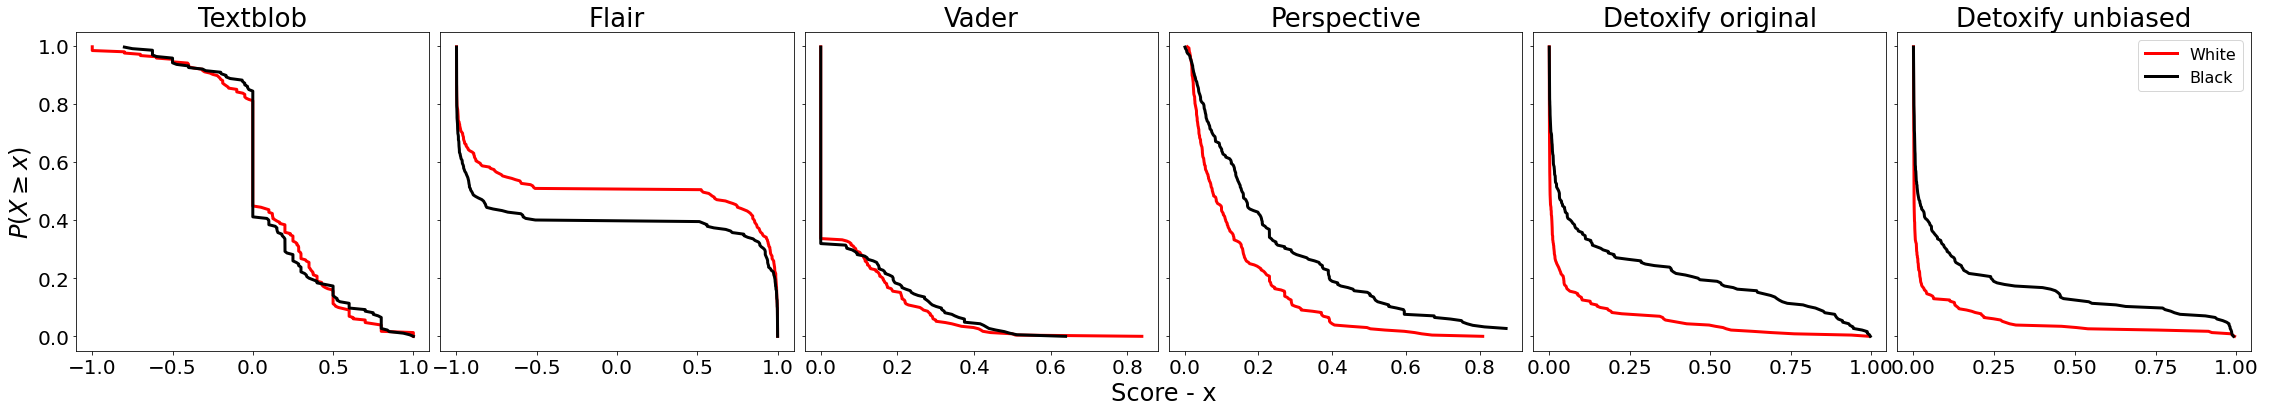

In [5]:
group_color = {
    "White": "red",
    "Black": "black",
}

fig, axs = plt.subplots(1, 6, figsize=(32, 6), sharey=True)

for i, SCORE_NAME in enumerate(
    tqdm(
        [
            "textblob",
            "flair",
            "vader",
            "perspective",
            "detoxify_original",
            "detoxify_unbiased",
        ]
    )
):
    for group in group_color.keys():
        df_group = df_data_desc[df_data_desc.group == group]

        dfs = []
        count = 0
        for filename in df_group.filename.values:
            try:
                df = pd.read_csv(os.path.join(twitter_datapath, filename))
                dfs.append(df)
            except:
                count += 1

        df = pd.concat(dfs)
        del dfs
        
        df = df[~df.has_swearing]
        
        ecdf = ECDF(df[f"{SCORE_NAME}_score"])
        axs[i].plot(ecdf.x, 1-ecdf.y, label=group, c=group_color[group])
        
    axs[i].set_title(f"{SCORE_NAME.replace('_', ' ').capitalize()}", fontsize=26)
#     axs[i].set_xlim(-0.01, 1)

plt.legend()
    
fig.add_subplot(111, frameon=False)
plt.tick_params(labelcolor='none', which='both', top=False, bottom=False, left=False, right=False)
plt.xlabel("Score - x", fontsize=24)
plt.ylabel(r"$P(X \geq x)$", fontsize=24)
plt.tight_layout(pad=0)
# plt.savefig(
#     os.path.join(
#         AbsolutePathBuilder.get_path(
#             "twitter_imgs",
#             filepaths="../../../../config/filepaths.yaml"
#         ),
#         f"twitter_icdfs_appendix_wo_swear.pdf"
#     )
# )
plt.show()

---

### Two-Sample Kolmogorov-Smirnov's Test

In [6]:
dfs = []
for group in group_color.keys():
    df_group = df_data_desc[df_data_desc.group == group]

    dfs_group = []
    count = 0
    for filename in df_group.filename.values:
        try:
            df = pd.read_csv(os.path.join(twitter_datapath, filename))
            dfs_group.append(df)
        except:
            count += 1

    df = pd.concat(dfs_group)
    df["group"] = group
    df = df[~df.has_swearing]

    del dfs_group
    dfs.append(df)
    
df = pd.concat(dfs)

In [7]:
for i, SCORE_NAME in enumerate(
    tqdm(
        [
            "perspective",
            "detoxify_original",
            "detoxify_unbiased",
            "vader",
            "flair",
            "textblob",
        ]
    )
):
    print(f"-----------------------------------------")
    print(f"Iniciando execução do modelo {SCORE_NAME}")

    statistic, p_value = ks_2samp(
        df[df.group == "White"][f"{SCORE_NAME}_score"],
        df[df.group == "Black"][f"{SCORE_NAME}_score"]
    )

    print(f"KS: {np.abs(np.round(statistic*100, 3))}")
    print(f"P-Valor: {np.round(p_value, 3)}")

100%|██████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 480.77it/s]

-----------------------------------------
Iniciando execução do modelo perspective
KS: 25.189
P-Valor: 0.0
-----------------------------------------
Iniciando execução do modelo detoxify_original
KS: 30.375
P-Valor: 0.0
-----------------------------------------
Iniciando execução do modelo detoxify_unbiased
KS: 31.594
P-Valor: 0.0
-----------------------------------------
Iniciando execução do modelo vader
KS: 5.44
P-Valor: 0.899
-----------------------------------------
Iniciando execução do modelo flair
KS: 14.713
P-Valor: 0.02
-----------------------------------------
Iniciando execução do modelo textblob
KS: 7.127
P-Valor: 0.638
